In [1]:
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio import Affine
import rioxarray as riox
import xarray as xr
import glob
import os
import numpy as np
import re
import pandas as pd
from tqdm import tqdm

In [2]:
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

In [3]:
shp_path = './ground_data/historical/pDog_*.shp'
cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pastures_2017_clip.shp'
cell_size = 5.0

shp_f_LIST = glob.glob(shp_path)

In [4]:
cper = gpd.read_file(cper_f)

<AxesSubplot:>

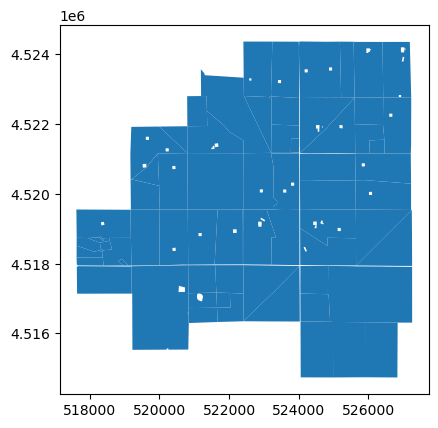

In [5]:
cper.plot()

In [6]:
transform = rio.transform.from_origin(cper.total_bounds[0],cper.total_bounds[3],cell_size, cell_size)
cper_ras = features.rasterize(zip(cper.geometry, cper.OBJECTID),
                   fill=0, 
                   transform=transform,
                   out_shape=(int(np.ceil((cper.total_bounds[3] - cper.total_bounds[1])/cell_size)),
                              int(np.ceil((cper.total_bounds[2] - cper.total_bounds[0])/cell_size))),
                   dtype=int)

In [13]:
cper_xr = xr.DataArray(cper_ras, 
             coords=(np.arange(cper.total_bounds[3], cper.total_bounds[1], -cell_size),
                    np.arange(cper.total_bounds[0], cper.total_bounds[2], cell_size)),
             dims=('y', 'x'))

In [14]:
#cper_xr = cper_xr.where(cper_xr != 0)

In [15]:
yrs_xr_list = []
for shp_f in tqdm(shp_f_LIST):
    yr = int(re.sub('.shp', '', os.path.basename(shp_f).split('_')[1]))
    gdf_yr = gpd.read_file(shp_f)
    gdf_yr = gdf_yr.to_crs(32613)
    yr_xr = shp2mask(gdf_yr.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape)
    yr_xr['Year'] = yr
    yrs_xr_list.append(yr_xr)

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.30it/s]


In [16]:
if not os.path.exists('./ground_data/historical/tifs/'):
    os.mkdir('./ground_data/historical/tifs/')

In [18]:
da_colony = xr.concat(yrs_xr_list, dim='Year').reset_index(['Year', 'y', 'x'])
da_colony.name = 'colony'
da_colony = da_colony.rio.write_crs(32613).rio.reproject(32613)#.sortby(['Year', 'y', 'x'])
da_colony.to_netcdf('./ground_data/historical/tifs/pdog_binary_2011_2021_30m.nc')